##Sección 2: Pyspark

PySpark: Pregunta 4: Se cuenta con dos listas que contienen información de los jugadores de fútbol mejor rankeados a nivel mundial y otra lista con el catálogo de países al que pertenecen.
PEDIDOS:

4.1 Crear dos dataframes en función de las listas entregadas.

4.2. Consolidar los datos y crear una marca que permita identificar el mejor jugador rankeado por país.

4.3. Proponga un nuevo ranking en base a un indicador diseñado por usted que permita considerar no solamente los goles logrados, sinó que tenga en cuenta el número de partidos que necesitó para lograr esa cantidad de goles.

4.4 Almacenar el resultado en un archivo json ubicado en la ruta /tmp/Nuevo_Ranking.json con la siguiente estructura de ejemplo: image.png

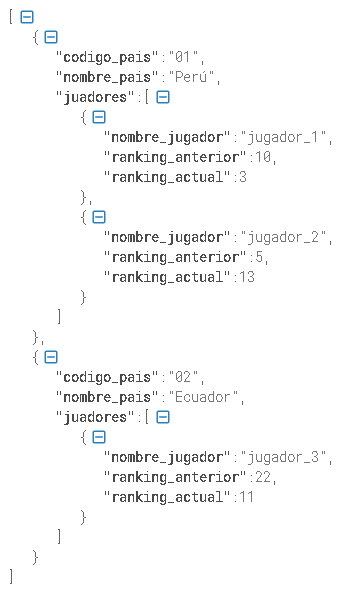

In [34]:
%pip install pyspark[hadoop]

In [35]:
%pip install l -q findspark

In [36]:
!apt-get update
!apt-get install openjdk-11-jdk -y

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:8 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:11 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Fetched 3,632 B in 1s (2,438 B/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (

In [37]:
!java -version

openjdk version "11.0.28" 2025-07-15
OpenJDK Runtime Environment (build 11.0.28+6-post-Ubuntu-1ubuntu122.04.1)
OpenJDK 64-Bit Server VM (build 11.0.28+6-post-Ubuntu-1ubuntu122.04.1, mixed mode, sharing)


In [38]:

# Ejercicio 8 Pyspark

import sys
from pyspark.mllib.random import RandomRDDs
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.sql import functions as F

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

# esquema de jugador: [(ranking, nombre, codigo_pais, numero_goles, numero_partidos_jugados)]
jugador = [("1", "Cristiano Ronaldo", "32", "115", "184"),("2", "Ali Daei", "24", "109", "148"),("3", "Mokhtar Dahari", "28", "89", "142"),("4", "Ferenc Puskás", "20", "84", "89"),("5", "Lionel Messi", "5", "81", "158"),("6", "Sunil Chhetri", "21", "80", "125"),("7", "Ali Mabkhout", "13", "79", "104"),("8", "Godfrey Chitalu", "39", "79", "111"),("9", "Hussein Saeed", "23", "78", "137"),("10", "Pelé", "8", "77", "92"),("11", "Sándor Kocsis", "19", "75", "68"),("12", "Kunishige Kamamoto", "26", "75", "76"),("13", "Bashar Abdullah", "27", "75", "134"),("14", "Robert Lewandowski", "31", "74", "128"),("15", "Majed Abdullah", "4", "72", "117"),("16", "Kinnah Phiri", "29", "71", "117"),("17", "Kiatisuk Senamuang", "36", "71", "134"),("18", "Miroslav Klose", "1", "71", "137"),("19", "Piyapong Pue-on", "36", "70", "100"),("20", "Abdul Kadir", "22", "70", "111"),("21", "Stern John", "37", "70", "115"),("22", "Neymar", "8", "70", "116"),("23", "Gerd Müller", "2", "68", "62"),("24", "Romelu Lukaku", "6", "68", "101"),("25", "Carlos Ruiz Gutiérrez", "17", "68", "133"),("26", "Robbie Keane", "25", "68", "146"),("27", "Hossam Hassan", "12", "68", "176"),("28", "Luis Suárez", "38", "67", "130"),("29", "Didier Drogba", "11", "65", "105"),("30", "Jasem Al-Huwaidi", "27", "63", "83"),("31", "Ronaldo Nazario", "8", "62", "98"),("32", "Zlatan Ibrahimović", "35", "62", "120"),("33", "Ahmed Radhi", "23", "62", "121"),("34", "Abdul Ghani Minhat", "16", "61", "71"),("35", "Edin Džeko", "7", "60", "118"),("36", "Imre Schlosser", "19", "59", "68"),("37", "David Villa", "14", "59", "98"),("38", "Cha Bum-Kun", "10", "58", "135"),("39", "Ali Ashfaq", "30", "57", "89"),("40", "Carlos Pavón", "18", "57", "101"),("41", "Clint Dempsey", "15", "57", "141"),("42", "Younis Mahmoud", "23", "57", "148"),("43", "Landon Donovan", "15", "57", "157"),("44", "Samuel Eto'o", "9", "56", "118"),("45", "Romário", "8", "55", "70"),("46", "Kazuyoshi Miura", "26", "55", "89"),("47", "Jan Koller", "33", "55", "91"),("48", "Iswadi Idris", "22", "55", "97"),("49", "Fandi Ahmad", "34", "55", "101"),("50", "Joachim Streich", "3", "55", "102")]

# esquema de país: [(codigo_pais, nombre_pais)]
pais = [("1", " Alemania"),("2", " Alemania Federal"),("3", " Alemania Oriental"),("4", " Arabia Saudita"),("5", " Argentina"),("6", " Bélgica"),("7", " Bosnia y Herzegovina"),("8", " Brasil"),("9", " Camerún"),("10", " Corea del Sur"),("11", " Costa de Marfil"),("12", " Egipto"),("13", " Emiratos Arabes Unidos"),("14", " España"),("15", " Estados Unidos"),("16", " Federación Malaya/ Malasia"),("17", " Guatemala"),("18", " Honduras"),("19", " Hungría"),("20", " Hungría/ España"),("21", " India"),("22", " Indonesia"),("23", " Irak"),("24", " Irán"),("25", " Irlanda"),("26", " Japón"),("27", " Kuwait"),("28", " Malasia"),("29", " Malawi"),("30", " Maldivas"),("31", " Polonia"),("32", " Portugal"),("33", " República Checa"),("34", " Singapur"),("35", " Suecia"),("36", " Tailandia"),("37", " Trinidad y Tobago"),("38", " Uruguay"),("39", " Zambia")]

####### PROGRAME SU RESPUESTA AQUI ##############


# Respuesta 4.1
# Crear dos dataframes en función de las listas entregadas.
schema_jugador = StructType([
    StructField("ranking", StringType(), True),
    StructField("nombre_jugador", StringType(), True),
    StructField("codigo_pais", StringType(), True),
    StructField("numero_goles", StringType(), True),
    StructField("numero_partidos_jugados", StringType(), True)
])

df_jugadores = spark.createDataFrame(jugador, schema=schema_jugador)

schema_pais = StructType([
    StructField("codigo_pais", StringType(), True),
    StructField("nombre_pais", StringType(), True)
])

df_paises = spark.createDataFrame(pais, schema=schema_pais)

print("DataFrame de Jugadores:")
df_jugadores.show()
print("DataFrame de Paises:")
df_paises.show()

# Respuesta 4.2.
# Consolidar los datos y crear una marca que permita identificar el mejor jugador rankeado por país.
df_consolidado = df_jugadores.join(df_paises, on="codigo_pais", how="inner")

# Convertir la columna 'ranking' a tipo entero para poder comparar
df_consolidado = df_consolidado.withColumn("ranking_int", df_consolidado["ranking"].cast(IntegerType()))

# Definir la ventana para el ranking por país
window_spec = Window.partitionBy("codigo_pais").orderBy("ranking_int")

# Añadir la marca del mejor jugador rankeado por país
df_consolidado = df_consolidado.withColumn(
    "es_mejor_rankeado_por_pais",
    F.when(F.rank().over(window_spec) == 1, True).otherwise(False)
)

print("DataFrame Consolidado con marca de mejor jugador por país:")
df_consolidado.show()

# Respuesta 4.3.
# Proponga un nuevo ranking en base a un indicador diseñado por usted que permita considerar no solamente los goles logrados,
# sino que tenga en cuenta el número de partidos que necesitó para lograr esa cantidad de goles.

# Convertir las columnas relevantes a tipo numérico
df_ranking_propuesto = df_consolidado.withColumn("numero_goles_int", df_consolidado["numero_goles"].cast(IntegerType())) \
                                     .withColumn("numero_partidos_jugados_int", df_consolidado["numero_partidos_jugados"].cast(IntegerType()))

# Proponer un nuevo indicador: "eficiencia_goles" (goles por partido)
# Para evitar división por cero, manejamos los casos donde numero_partidos_jugados_int es 0.
df_ranking_propuesto = df_ranking_propuesto.withColumn(
    "eficiencia_goles",
    F.when(F.col("numero_partidos_jugados_int") > 0, F.col("numero_goles_int") / F.col("numero_partidos_jugados_int")).otherwise(0.0)
)

# Crear un nuevo ranking basado en la eficiencia de goles (mayor eficiencia es mejor)
window_ranking_global = Window.orderBy(F.col("eficiencia_goles").desc(), F.col("numero_goles_int").desc())
df_ranking_propuesto = df_ranking_propuesto.withColumn(
    "nuevo_ranking_global",
    F.rank().over(window_ranking_global)
)

print("DataFrame con nuevo ranking propuesto:")
df_ranking_propuesto.select("nombre_jugador", "nombre_pais", "numero_goles", "numero_partidos_jugados", "eficiencia_goles", "nuevo_ranking_global").show()

# Respuesta 4.4
# Almacenar el resultado en un archivo json ubicado en la ruta /tmp/Nuevo_Ranking.json con la estructura de ejemplo dado:

# Seleccionar y renombrar las columnas para la estructura final
df_final_json = df_ranking_propuesto.select(
    F.col("codigo_pais"),
    F.col("nombre_pais"),
    F.struct(
        F.col("nombre_jugador"),
        F.col("ranking_int").alias("ranking_anterior"),
        F.col("nuevo_ranking_global").alias("ranking_actual")
    ).alias("jugador_info")
)

# Agrupar por país y recolectar los jugadores en una lista
df_final_json = df_final_json.groupBy("codigo_pais", "nombre_pais") \
                             .agg(F.collect_list("jugador_info").alias("jugadores")) \
                             .orderBy("codigo_pais")

# Guardar el resultado en un archivo JSON
output_path = "/tmp/Nuevo_Ranking.json"
df_final_json.write.mode("overwrite").json(output_path)

print(f"Resultado guardado en {output_path}")

spark.stop()


DataFrame de Jugadores:
+-------+------------------+-----------+------------+-----------------------+
|ranking|    nombre_jugador|codigo_pais|numero_goles|numero_partidos_jugados|
+-------+------------------+-----------+------------+-----------------------+
|      1| Cristiano Ronaldo|         32|         115|                    184|
|      2|          Ali Daei|         24|         109|                    148|
|      3|    Mokhtar Dahari|         28|          89|                    142|
|      4|     Ferenc Puskás|         20|          84|                     89|
|      5|      Lionel Messi|          5|          81|                    158|
|      6|     Sunil Chhetri|         21|          80|                    125|
|      7|      Ali Mabkhout|         13|          79|                    104|
|      8|   Godfrey Chitalu|         39|          79|                    111|
|      9|     Hussein Saeed|         23|          78|                    137|
|     10|              Pelé|          8|

####PySpark: Pregunta 5:  Subir el archivo CENTROS_EDUCACION_MADRID.json a la ruta /content
<b> 5.1 Preparar un programa de pyspark que permita leer el archivo "CENTROS_EDUCACION_MADRID.json".

<b> 5.2 Periódicamente se realizarán reuniones de todos los centros que pertenezcan a un mismo "centro_titularidad" y se necesita determinar qué Centro educativo es el mas céntrico.   Para esto se cuenta con las coordenadas de cada centro educativo ("direccion_coor_x" y "direccion_coor_y").   

Procedimiento sugerido:  
   5.2.1  Determinar el promedio de las coordenadas "x" y "y" por cada grupo "centro_titularidad".

   5.2.2  Crear una udf que permita calcular la distancia euclideana desde cada unidad educativa del grupo hacia este punto promedio.

   5.2.3  Identificar cuál es la unidad educativa con menor distancia dentro de cada grupo.  Esta será la elegida como centro de reunión.

* DISTANCIA EUCLIDIANA
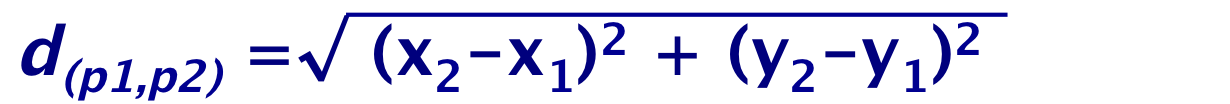


In [39]:
from typing import cast
import sys
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import explode, col, desc, avg, min, max, rank, asc, round
from pyspark.sql import Window
from math import sqrt
from pyspark.sql.functions import udf

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

####### PROGRAME SU RESPUESTA AQUI ##############

# 5.1 Leer el archivo "CENTROS_EDUCACION_MADRID.json"

try:
    df = spark.read.option("multiline", "true").json("/content/CENTROS_EDUCATIVOS_MADRID.json") # Corrected file path and added multiline option
    print("Archivo CENTROS_EDUCATIVOS_MADRID.json leído exitosamente.")
except Exception as e:
    print(f"Error al leer el archivo: {e}")
    # If the file is not found, inform the user.
    print("Please ensure the file 'CENTROS_EDUCATIVOS_MADRID.json' is uploaded to /content/.")

#################################################

# spark.stop() # Removed spark.stop() here to allow subsequent cells to use the spark session

Archivo CENTROS_EDUCATIVOS_MADRID.json leído exitosamente.


In [40]:
# 5.2 Determinar qué Centro educativo es el más céntrico por "centro_titularidad"

# 5.2.1 Determinar el promedio de las coordenadas "x" y "y" por cada grupo "centro_titularidad".
df_promedios = df.groupBy("centro_titularidad").agg(
    avg("direccion_coor_x").alias("promedio_x"),
    avg("direccion_coor_y").alias("promedio_y")
)
print("Promedios de coordenadas por centro_titularidad:")
df_promedios.show()

# Unir el DataFrame original con los promedios
df_unido = df.join(df_promedios, on="centro_titularidad", how="left")
print("DataFrame unido con promedios:")
df_unido.show()

# 5.2.2 Crear una udf que permita calcular la distancia euclidiana
def calcular_distancia_euclidiana(x1, y1, x2, y2):
    if None in [x1, y1, x2, y2]:
        return None
    return sqrt((x1 - x2)**2 + (y1 - y2)**2)

udf_distancia_euclidiana = udf(calcular_distancia_euclidiana, DoubleType())

# Aplicar la UDF para calcular la distancia de cada centro al punto promedio de su grupo
df_con_distancia = df_unido.withColumn(
    "distancia_al_promedio",
    udf_distancia_euclidiana(
        col("direccion_coor_x"),
        col("direccion_coor_y"),
        col("promedio_x"),
        col("promedio_y")
    )
)
print("DataFrame con distancias al promedio:")
df_con_distancia.show()

# 5.2.3 Identificar cuál es la unidad educativa con menor distancia dentro de cada grupo.
# Esta será la elegida como centro de reunión.
window_spec = Window.partitionBy("centro_titularidad").orderBy(asc("distancia_al_promedio"))

df_centro_mas_centrico = df_con_distancia.withColumn("rank", rank().over(window_spec)) \
                                        .filter(col("rank") == 1) \
                                        .select("centro_titularidad", "centro_nombre", # Corrected column name
                                                round(col("direccion_coor_x"), 6).alias("coordenada_x"),
                                                round(col("direccion_coor_y"), 6).alias("coordenada_y"),
                                                round(col("distancia_al_promedio"), 6).alias("distancia_minima"))

print("Centro educativo más céntrico por titularidad:")
df_centro_mas_centrico.show(truncate=False)

Promedios de coordenadas por centro_titularidad:
+--------------------+-----------------+-----------------+
|  centro_titularidad|       promedio_x|       promedio_y|
+--------------------+-----------------+-----------------+
|             PÚBLICO|440157.3842874543|4474481.943970768|
|             PRIVADO|439602.9362934363|4476838.754826255|
|  PRIVADO CONCERTADO|440264.7489361702|4474293.580851064|
|PÚBLICO-TITULARID...|         438924.0|        4479147.0|
+--------------------+-----------------+-----------------+

DataFrame unido con promedios:
+------------------+-------------+--------------------+------------------+--------------------------+-----------------------+--------------------+--------------------+------------+------------------+------------------+------------------+------------------+--------------------+----------+-----------+-----------------------+----------------+----------------+----------------+--------------------+------------------+---------------+---------------+

<b> 5.3 Exportar el resultado del ejercicio anterior en tres formatos:
1. parquet
2. json
3. csv (separado por caracter '|' y conservando la cabecera de la data)

Los tres archivos deberán crearse en la ruta /tmp

5.4.  Qué formato utilizaría para almacenar y procesar grandes volúmenes de datos en Databricks.  Justifique porqué no seleccionó los otros dos formatos.

<b>Nota:  Desarrolle su análisis en el espacio comentado

In [41]:
from typing import cast
import sys
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import explode, col, desc, avg, min, max, rank, asc, round
from pyspark.sql import Window
from math import sqrt
from pyspark.sql.functions import udf


####### PROGRAME SU RESPUESTA AQUI ##############


# 5.3 Respuesta:

output_path = "/tmp/centro_mas_centrico"

# Exportar a formato parquet
df_centro_mas_centrico.write.mode("overwrite").parquet(f"{output_path}.parquet")
print(f"Result exported to {output_path}.parquet (parquet format)")

# Exportar a formato json
df_centro_mas_centrico.write.mode("overwrite").json(f"{output_path}.json")
print(f"Result exported to {output_path}.json (json format)")

# Exportar a formato csv
df_centro_mas_centrico.write.mode("overwrite").option("sep", "|").option("header", "true").csv(f"{output_path}.csv")
print(f"Result exported to {output_path}.csv (csv format separated by '|' with header)")


# 5.4 Justificación:

# Para almacenar y procesar grandes volúmenes de datos en Databricks, el formato más adecuado es Parquet.

# Justificación:

# 1.  Rendimiento:
#     Parquet es un formato de almacenamiento columnar, lo que significa que los datos se almacenan por columnas en lugar de por filas.
#     Esto es altamente eficiente para cargas de trabajo analíticas donde se suelen leer subconjuntos de columnas.
#     Spark y Databricks están optimizados para trabajar con formatos columnares como Parquet, lo que resulta en un rendimiento de lectura y escritura significativamente mejor
#     en comparación con formatos basados en filas como CSV y JSON para grandes conjuntos de datos.

# 2.  Compresión y Codificación:
#     Parquet soporta esquemas de compresión y codificación eficientes (como Snappy, Gzip, LZO), lo que reduce el espacio de almacenamiento necesario y la cantidad de datos
#     que deben ser leídos desde el disco, mejorando aún más el rendimiento.

# 3.  Esquema Evolutivo:
#     Parquet maneja bien los cambios en el esquema de los datos (agregar o eliminar columnas) sin romper la compatibilidad hacia atrás.
#     Esto es importante en entornos de datos dinámicos.

# 4.  Integración con Spark y Databricks:
#     Parquet es el formato nativo y recomendado para Spark y Databricks, la integración es perfecta, lo que permite aprovechar al máximo las optimizaciones de rendimiento
#     y las características de estos entornos.

# Por qué no seleccionaría los otros dos formatos (JSON y CSV) para grandes volúmenes de datos en Databricks:

#    Formato JSON:
#    Aunque flexible y legible, este es un formato basado en filas y no es tan eficiente para la lectura de columnas específicas.
#    Para grandes volúmenes, la lectura de datos JSON puede ser más lenta y consumir más recursos debido a la necesidad de analizar cada registro individualmente.
#    Además, manejar esquemas anidados en JSON puede añadir varios grados de complejidad innecesarios.
#
#    Formto CSV:
#    Es simple y ampliamente compatible, pero también es basado en filas, no soporta compresión y codificación eficientes como Parquet.
#    La lectura de grandes archivos CSV puede ser ineficiente, especialmente si solo se necesitan algunas columnas, ya que el sistema tiene que leer el archivo completo.
#    Además, CSV no tiene un esquema incorporado, lo que puede llevar a problemas de inferencia de tipos y calidad de datos.

# Por lo tanto, mientras que JSON y CSV son útiles para el intercambio de datos y conjuntos de datos más pequeños,
# Parquet es claramente superior para el almacenamiento y procesamiento de grandes volúmenes de datos en Databricks
# debido a su naturaleza columnar, eficiencia en compresión y su optimización para el ecosistema de Spark/Databricks.

Result exported to /tmp/centro_mas_centrico.parquet (parquet format)
Result exported to /tmp/centro_mas_centrico.json (json format)
Result exported to /tmp/centro_mas_centrico.csv (csv format separated by '|' with header)


In [43]:
# Mediante las siguientes lineas de codigo se puede descargar los archivos generados en sus respectivos formatos de manera mas simple

import os
import shutil
from google.colab import files

# Rutas de los archivos y directorios generados
ranking_dir = "/tmp/Nuevo_Ranking.json"
parquet_dir = "/tmp/centro_mas_centrico.parquet"
json_dir = "/tmp/centro_mas_centrico.json"
csv_file = "/tmp/centro_mas_centrico.csv"


# Comprimir el directorio ranking
if os.path.exists(ranking_dir):
    shutil.make_archive('/tmp/Nuevo_Ranking.json', 'zip', ranking_dir)
    print(f"Comprimiendo {ranking_dir} a /tmp/Nuevo_Ranking.json.zip")
    files.download('/tmp/Nuevo_Ranking.json.zip')

# Comprimir el directorio Parquet
if os.path.exists(parquet_dir):
    shutil.make_archive('/tmp/centro_mas_centrico_parquet', 'zip', parquet_dir)
    print(f"Comprimiendo {parquet_dir} a /tmp/centro_mas_centrico_parquet.zip")
    files.download('/tmp/centro_mas_centrico_parquet.zip')

# Comprimir el directorio JSON
if os.path.exists(json_dir):
    shutil.make_archive('/tmp/centro_mas_centrico_json', 'zip', json_dir)
    print(f"Comprimiendo {json_dir} a /tmp/centro_mas_centrico_json.zip")
    files.download('/tmp/centro_mas_centrico_json.zip')

# Comprimir el directorio CSV
if os.path.exists(csv_file):
    shutil.make_archive('/tmp/centro_mas_centrico_csv', 'zip', csv_file)
    print(f"Comprimiendo {csv_file} a /tmp/centro_mas_centrico_csv.zip")
    files.download('/tmp/centro_mas_centrico_csv.zip')



Comprimiendo /tmp/Nuevo_Ranking.json a /tmp/Nuevo_Ranking.json.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Comprimiendo /tmp/centro_mas_centrico.parquet a /tmp/centro_mas_centrico_parquet.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Comprimiendo /tmp/centro_mas_centrico.json a /tmp/centro_mas_centrico_json.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Comprimiendo /tmp/centro_mas_centrico.csv a /tmp/centro_mas_centrico_csv.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>